## 範例重點
* 了解如何在 Keras 中，加入 regularization
* 熟悉建立、訓練模型
* 熟悉將訓練結果視覺化並比較結果

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W1022 13:50:43.183820 11412 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1022 13:50:43.188809 11412 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1022 13:50:43.872419 11412 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1022 13:50:43.874398 11412 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1022 13:50:43.886392 11412 

Experiment with Regulizer = 0.010000
_________________________________________________________________

W1022 13:50:44.082737 11412 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.




Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W1022 13:50:44.576622 11412 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 257us/step - loss: 15.1373 - acc: 0.2574 - val_loss: 13.9922 - val_acc: 0.3238
Epoch 2/50
50000/50000 [==============================] - 13s 259us/step - loss: 13.0512 - acc: 0.3485 - val_loss: 12.1586 - val_acc: 0.3611
Epoch 3/50
50000/50000 [==============================] - 13s 262us/step - loss: 11.3721 - acc: 0.3733 - val_loss: 10.6167 - val_acc: 0.3826
Epoch 4/50
50000/50000 [==============================] - 13s 260us/step - loss: 9.9519 - acc: 0.3895 - val_loss: 9.3204 - val_acc: 0.3890
Epoch 5/50
50000/50000 [==============================] - 13s 259us/step - loss: 8.7480 - acc: 0.4013 - val_loss: 8.2109 - val_acc: 0.4047
Epoch 6/50
50000/50000 [==============================] - 14s 273us/step - loss: 7.7226 - acc: 0.4115 - val_loss: 7.2607 - val_acc: 0.4121
Epoch 7/50
50000/50000 [==============================] - 13s 255us/step - loss: 6.8491 - acc: 0.4161 - val_lo

50000/50000 [==============================] - 12s 238us/step - loss: 2.1695 - acc: 0.2684 - val_loss: 2.0073 - val_acc: 0.3406
Epoch 2/50
50000/50000 [==============================] - 12s 242us/step - loss: 1.9528 - acc: 0.3645 - val_loss: 1.9033 - val_acc: 0.3797
Epoch 3/50
50000/50000 [==============================] - 13s 254us/step - loss: 1.8685 - acc: 0.3958 - val_loss: 1.8410 - val_acc: 0.4083
Epoch 4/50
50000/50000 [==============================] - 13s 259us/step - loss: 1.8061 - acc: 0.4160 - val_loss: 1.7844 - val_acc: 0.4223
Epoch 5/50
50000/50000 [==============================] - 12s 243us/step - loss: 1.7546 - acc: 0.4346 - val_loss: 1.7456 - val_acc: 0.4389
Epoch 6/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.7137 - acc: 0.4487 - val_loss: 1.7065 - val_acc: 0.4517
Epoch 7/50
50000/50000 [==============================] - 13s 261us/step - loss: 1.6785 - acc: 0.4611 - val_loss: 1.6828 - val_acc: 0.4574
Epoch 8/50
50000/50000 [==============

Epoch 2/50
50000/50000 [==============================] - 13s 256us/step - loss: 1.8148 - acc: 0.3649 - val_loss: 1.7636 - val_acc: 0.3818
Epoch 3/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.7269 - acc: 0.3962 - val_loss: 1.7078 - val_acc: 0.3999
Epoch 4/50
50000/50000 [==============================] - 12s 250us/step - loss: 1.6641 - acc: 0.4185 - val_loss: 1.6387 - val_acc: 0.4283
Epoch 5/50
50000/50000 [==============================] - 15s 293us/step - loss: 1.6122 - acc: 0.4343 - val_loss: 1.6031 - val_acc: 0.4313
Epoch 6/50
50000/50000 [==============================] - 17s 348us/step - loss: 1.5727 - acc: 0.4471 - val_loss: 1.5730 - val_acc: 0.4476
Epoch 7/50
50000/50000 [==============================] - 18s 354us/step - loss: 1.5388 - acc: 0.4592 - val_loss: 1.5538 - val_acc: 0.4573
Epoch 8/50
50000/50000 [==============================] - 17s 349us/step - loss: 1.5091 - acc: 0.4712 - val_loss: 1.5291 - val_acc: 0.4656
Epoch 9/50
50000/50000 [===

50000/50000 [==============================] - 12s 246us/step - loss: 1.8212 - acc: 0.3585 - val_loss: 1.7681 - val_acc: 0.3835
Epoch 3/50
50000/50000 [==============================] - 12s 234us/step - loss: 1.7284 - acc: 0.3927 - val_loss: 1.6977 - val_acc: 0.3968
Epoch 4/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.6658 - acc: 0.4162 - val_loss: 1.6575 - val_acc: 0.4174
Epoch 5/50
50000/50000 [==============================] - 15s 300us/step - loss: 1.6184 - acc: 0.4332 - val_loss: 1.6109 - val_acc: 0.4343
Epoch 6/50
50000/50000 [==============================] - 15s 296us/step - loss: 1.5786 - acc: 0.4457 - val_loss: 1.5760 - val_acc: 0.4418
Epoch 7/50
50000/50000 [==============================] - 12s 249us/step - loss: 1.5447 - acc: 0.4567 - val_loss: 1.5440 - val_acc: 0.4596
Epoch 8/50
50000/50000 [==============================] - 13s 259us/step - loss: 1.5160 - acc: 0.4651 - val_loss: 1.5345 - val_acc: 0.4605
Epoch 9/50
50000/50000 [==============

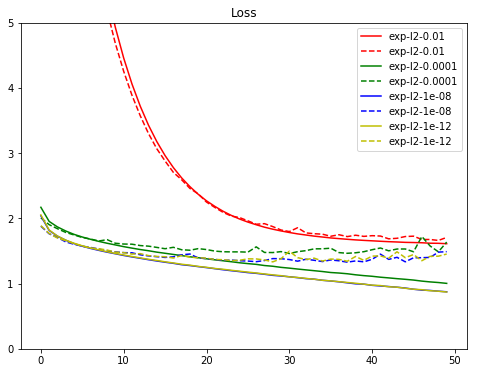

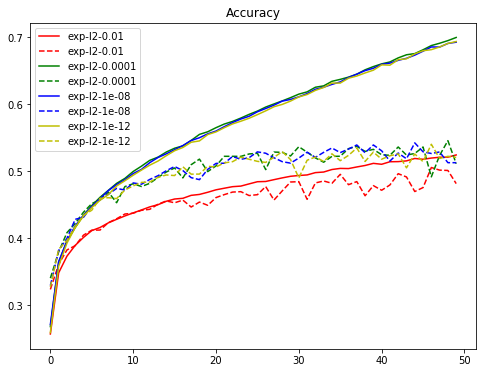

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果